https://github.com/campbwa/R-videos/blob/master/titanic%20gbm.R

In [1]:
# GBM: Generalized Boosted Models
# an ensemble of classification or regression trees
# with the gbm package, you can do both a few different kinds including 
# AdaBoost and Gradient Boosting 

#### Advantages of GBM over logistic regression (parametric method):
* robust to outliers
* can still make predictions when an observation has missing data!
* handles unequal class sizes and unbalanced predictor variables well (logistic regression isn't as good at this)
* you don't need to specify interaction terms with tree models!
* usually have greater predictive ability

#### Potential drawbacks: 
* trees can overfit, especially if the number of ending nodes is too small or the number of trees is too large
* definitely want to use CV, can't use in-sample prediction rate as a measure of goodness of fit!

In [2]:
require(gbm)
require(dplyr)

Loading required package: gbm
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [3]:
############# Load and transform data #################
train = read.csv("https://raw.githubusercontent.com/campbwa/R-videos/master/data/train.csv")
test = read.csv("https://raw.githubusercontent.com/campbwa/R-videos/master/data/test.csv")
head(train)
summary(train)
# missing values of age! , from NA's in summary
# you can estimate gbm and make predictions on observations with missing values in the feature space (independent variables)
# I would still recommend imputing missing values

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


  PassengerId       Survived          Pclass     
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000  
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000  
 Median :446.0   Median :0.0000   Median :3.000  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309  
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000  
 Max.   :891.0   Max.   :1.0000   Max.   :3.000  
                                                 
                                    Name         Sex           Age       
 Abbing, Mr. Anthony                  :  1   female:314   Min.   : 0.42  
 Abbott, Mr. Rossmore Edward          :  1   male  :577   1st Qu.:20.12  
 Abbott, Mrs. Stanton (Rosa Hunt)     :  1                Median :28.00  
 Abelson, Mr. Samuel                  :  1                Mean   :29.70  
 Abelson, Mrs. Samuel (Hannah Wizosky):  1                3rd Qu.:38.00  
 Adahl, Mr. Mauritz Nils Martin       :  1                Max.   :80.00  
 (Other)                              :885                NA's   :177    
     Sib

In [4]:
####### Basic data manipulation ########
survived = train$Survived
train = dplyr::select(train, -Survived)
end_trn = nrow(train)

In [5]:
#combine the two into one data set
all = rbind(train,test)
#Why? So if we manipulate variables (create new ones, cap and floor), 
#we do the same operation for the training and testing data
end = nrow(all)

In [6]:
# Select variables to use in modeling (select is a dplyr function)
# gbm does a good job of filtering out noise variables, but will still
# get a better fit when you get rid of junk 
# (especially factor variables with lots of levels)
all = dplyr::select(all
             , Pclass
             , Sex
             , Age
             , SibSp
             , Parch
             , Fare
             , Embarked
             ) 
# not many variables to choose from
# perform variable selection later
head(all)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,3,male,22,1,0,7.25,S
2,1,female,38,1,0,71.2833,C
3,3,female,26,0,0,7.925,S
4,1,female,35,1,0,53.1,S
5,3,male,35,0,0,8.05,S
6,3,male,NA,0,0,8.4583,Q


In [7]:
########## The model #############
#as always, look at the help page for the function
#?gbm

In [8]:
# a high guess of how many trees we'll need
ntrees = 5000

#### How to tune parameters? 
In this video, we'll tune the number of trees and  use reasonable values of other parameters test different parameters with Cross Validation see the other video on this topic

In [9]:
Model = gbm.fit( 
  x = all[1:end_trn,] #dataframe of features
  , y = survived #dependent variable
  # two ways to fit the model
  # use gbm.fit if you are going to specify x = and y = 
  # instead of using a formula
  # if there are lots of features, I think it's easier to specify 
  # x and y instead of using a formula
  
  
  , distribution = "bernoulli"
  # use bernoulli for binary outcomes
  # other values are "gaussian" for GBM regression 
  # or "adaboost"
  
  
  , n.trees = ntrees
  # Choose this value to be large, then we will prune the
  # tree after running the model
  
  
  , shrinkage = 0.01 
  # smaller values of shrinkage typically give slightly better performance
  # the cost is that the model takes longer to run for smaller values
  
  
  , interaction.depth = 3
  # use cross validation to choose interaction depth!!
  
  
  , n.minobsinnode = 10
  # n.minobsinnode has an important effect on overfitting!
  # decreasing this parameter increases the in-sample fit, 
  # but can result in overfitting
  
  , nTrain = round(end_trn * 0.8)
  # use this so that you can select the number of trees at the end
  
  #, var.monotone = c() 
  # can help with overfitting, will smooth bumpy curves
  
  , verbose = TRUE #print the preliminary output
)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3309          1.2973     0.0100    0.0041
     2        1.3239          1.2902     0.0100    0.0033
     3        1.3171          1.2826     0.0100    0.0035
     4        1.3100          1.2754     0.0100    0.0038
     5        1.3032          1.2685     0.0100    0.0035
     6        1.2963          1.2609     0.0100    0.0034
     7        1.2898          1.2542     0.0100    0.0029
     8        1.2834          1.2472     0.0100    0.0034
     9        1.2766          1.2393     0.0100    0.0032
    10        1.2701          1.2323     0.0100    0.0032
    20        1.2129          1.1700     0.0100    0.0022
    40        1.1235          1.0712     0.0100    0.0018
    60        1.0605          1.0005     0.0100    0.0013
    80        1.0151          0.9536     0.0100    0.0009
   100        0.9809          0.9154     0.0100    0.0005
   120        0.9544          0.8840     0.0100    0.0004
   140        

,var,rel.inf
Fare,Fare,32.4779708914867
Age,Age,27.6742132627395
Sex,Sex,21.3837007244567
Pclass,Pclass,8.73394043503316
Embarked,Embarked,4.57186841302628
SibSp,SibSp,3.38430170199873
Parch,Parch,1.77400457125889


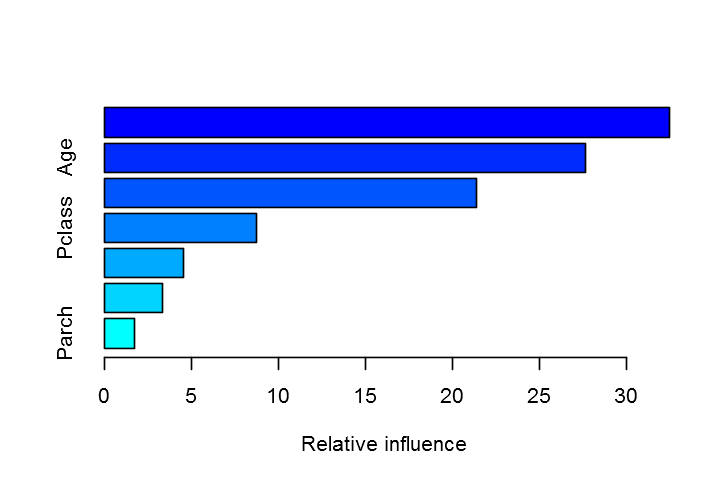

In [10]:
options(repr.plot.width = 6, repr.plot.height = 4)
# look at the last model built
# Relative influence among the variables can be used in variable selection
summary(Model)
# If you see one variable that's much more important than all of the rest,
# that could be evidence of overfitting.

Using test method...


[1] 1712

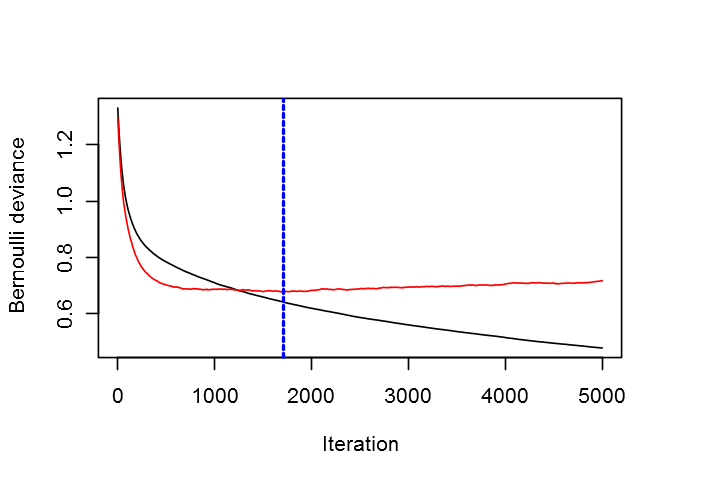

In [11]:
options(repr.plot.width = 6, repr.plot.height = 4)
#optimal number of trees based upon CV
gbm.perf(Model)

In [12]:
#look at the effects of each variable, does it make sense?
#?plot.gbm

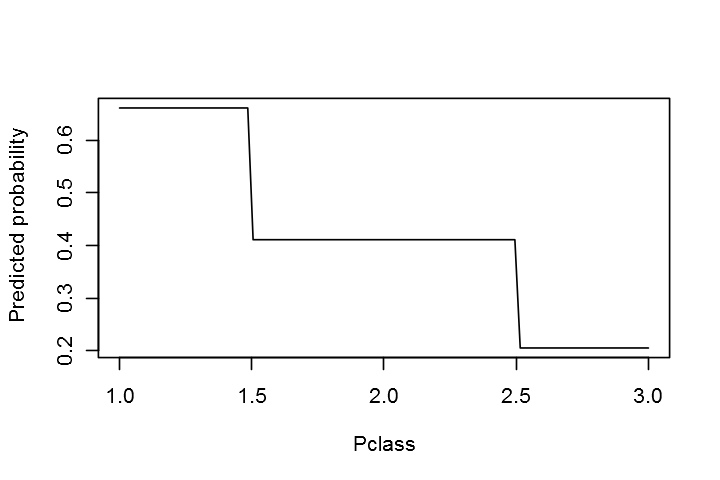

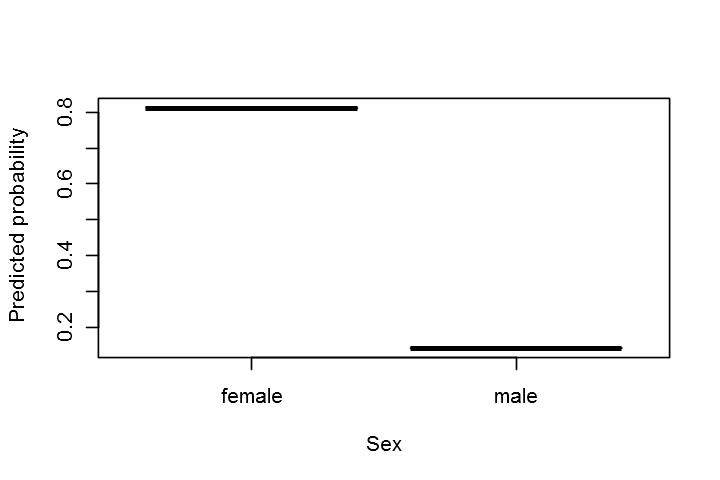

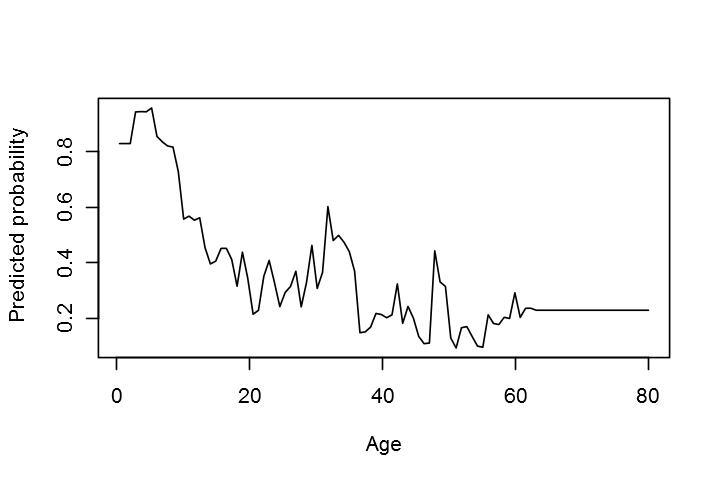

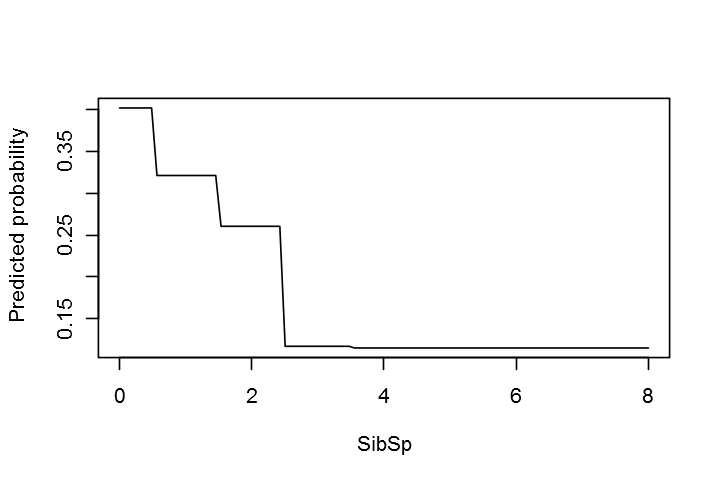

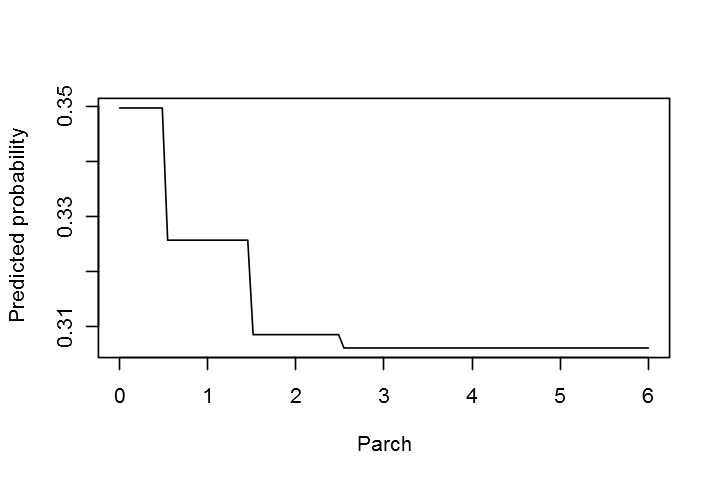

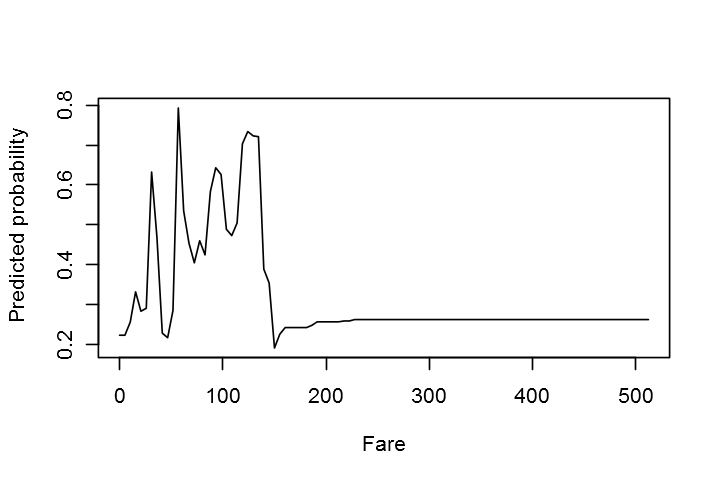

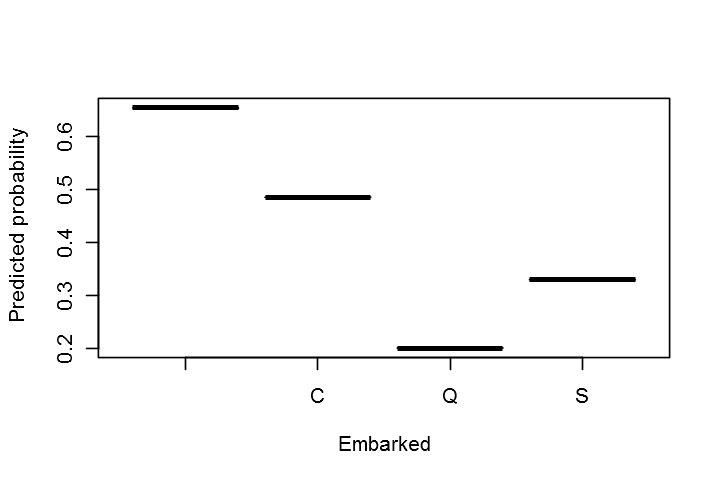

In [13]:
for(i in 1:length(Model$var.names)){
  plot(Model, i.var = i
       , ntrees = gbm.perf(Model, plot.it = FALSE) #optimal number of trees
       , type = "response" #to get fitted probabilities
       )
}

In [14]:
################ Make predictions ##################
#test set predictions
TestPredictions = predict(object = Model,newdata =all[(end_trn+1):end,]
                          , n.trees = gbm.perf(Model, plot.it = FALSE)
                          , type = "response") #to output a probability
#training set predictions
TrainPredictions = predict(object = Model,newdata =all[1:end_trn,]
                           , n.trees = gbm.perf(Model, plot.it = FALSE)
                           , type = "response")

Using test method...
Using test method...


In [15]:
# round the predictions to zero or one
# in general, don't do this!
# it was only because the answers in the comp had to be 0 or 1
TestPredictions = round(TestPredictions)
TrainPredictions = round(TrainPredictions)
# could also mess around with different cutoff values
# would need CV to determine the best

In [16]:
head(TrainPredictions, n = 20)
head(survived, n = 20)

[1] 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1

[1] 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1

In [17]:
#in sample classification accuracy
1 - sum(abs(survived - TrainPredictions)) / length(TrainPredictions) 
#depending upon the tuning parameters, 
#I've gotten this as high as 99%, but that model 
#resulted in lower test set scores

[1] 0.8742985

In [18]:
#in sample classification accuracy
1 - sum(abs(survived - TrainPredictions)) / length(TrainPredictions) 
#depending upon the tuning parameters, 
#I've gotten this as high as 99%, but that model 
#resulted in lower test set scores


#to get predicted out of sample accuracy
#need to set aside a testing data set

[1] 0.8742985

In [19]:
#write the submission
submission = data.frame(PassengerId = 1:nrow(test), survived = TestPredictions)
write.csv(submission, file = "./data/gbm submission.csv", row.names = FALSE)

In [20]:
#GBM vs Random Forests:
#https://www.nescent.org/wg/cart/images/9/91/Chapter6_March20.pdf
#difficult to know which method will be the best beforehand!
#"The jury is out on whether they are generally more powerful 
#than Random Forests; sometimes they are, sometimes not."